C:\Users\esteb\AppData\Local\Temp\ipykernel_28460\3602771303.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grid['count'].fillna(0, inplace=True)


Media = 1.46, Varianza = 3.14


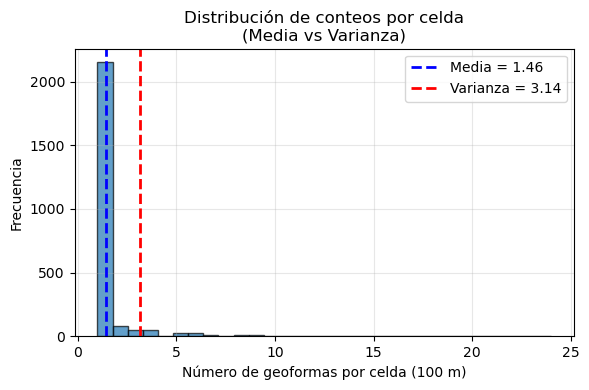

In [4]:
#  Histograma de conteos con líneas de Media y Varianza

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.ticker import FuncFormatter

ruta_contorno = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_puntos   = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
out_dir       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"

# Cargar datos 
cont = gpd.read_file(ruta_contorno).to_crs(epsg=9377)
pts  = gpd.read_file(ruta_puntos).to_crs(epsg=9377)

# Crear cuadrícula de 100×100 m sobre el contorno
cell_size = 100  
minx, miny, maxx, maxy = cont.total_bounds
cols = np.arange(minx, maxx, cell_size)
rows = np.arange(miny, maxy, cell_size)

polygons = [box(x, y, x+cell_size, y+cell_size)
            for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=cont.crs)

# Recortar la grilla al polígono de contorno
grid = gpd.overlay(grid, cont, how='intersection')

# Contar puntos en cada celda
join = gpd.sjoin(grid, pts, how='left', predicate='contains')
counts = join.groupby(join.index).size()
grid['count'] = counts
grid['count'].fillna(0, inplace=True)

# Calcular estadísticos
mean_cnt = grid['count'].mean()
var_cnt  = grid['count'].var()
print(f"Media = {mean_cnt:.2f}, Varianza = {var_cnt:.2f}")

# Histograma con líneas de Media y Varianza
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(grid['count'], bins=30, edgecolor='black', alpha=0.7)

# Líneas de media y varianza
ax.axvline(mean_cnt, color='blue', linestyle='--', linewidth=2,
           label=f"Media = {mean_cnt:.2f}")
ax.axvline(var_cnt,  color='red',  linestyle='--', linewidth=2,
           label=f"Varianza = {var_cnt:.2f}")

# Etiquetas y estilo
ax.set_xlabel("Número de geoformas por celda (100 m)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución de conteos por celda\n(Media vs Varianza)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

# Guardar figura
fig.savefig(f"{out_dir}/13_hist_media_varianza.png", dpi=300, bbox_inches='tight')

plt.show()


In [8]:
# GLM Binomial negativa

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
import libpysal.weights
from esda.moran import Moran, Moran_Local

# Rutas de entrada y salida 
ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
os.makedirs(output_dir, exist_ok=True)

gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)


# Generar cuadrícula y conteo
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)


# Extraer covoriables
grid['dem_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]


# Coberturas y distancias
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids= grid.copy(); centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)
union_drains = drains.geometry.unary_union
union_faults = faults.geometry.unary_union
grid['dist_drain'] = centroids.geometry.distance(union_drains)
grid['dist_fault'] = centroids.geometry.distance(union_faults)


# Prepara el dataframe para el modelado
df = grid[['count','dem_mean','slope_mean','twi_mean','dist_drain','dist_fault','cover']].copy()
df = df.dropna()
y = df['count'].astype(int)
X_vars = df.drop(columns=['count'])
X_vars = pd.get_dummies(X_vars, columns=['cover'], prefix='cov', drop_first=True)
X = sm.add_constant(X_vars.astype(float))
y = y[X.index]

model = sm.GLM(y, X, family=NegativeBinomial())
results = model.fit()
print("Resumen del Modelo GLM Binomial Negativo:")
print(results.summary())


C:\Users\esteb\AppData\Local\Temp\ipykernel_28460\706222395.py:59: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_drains = drains.geometry.unary_union
C:\Users\esteb\AppData\Local\Temp\ipykernel_28460\706222395.py:60: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_faults = faults.geometry.unary_union
C:\Users\esteb\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Resumen del Modelo GLM Binomial Negativo:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2426
Model:                            GLM   Df Residuals:                     2400
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3929.7
Date:                Thu, 26 Jun 2025   Deviance:                       485.48
Time:                        22:05:19   Pearson chi2:                 1.04e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08029
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

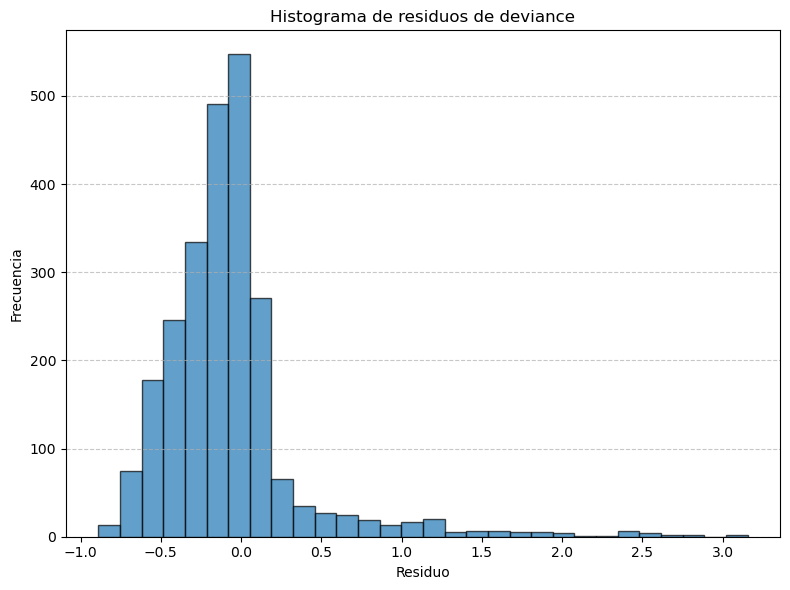

In [7]:
# Histograma de residuos

import os
import matplotlib.pyplot as plt

# Extraer residuos de deviance
resid_dev = results.resid_deviance

# Configurar salida
os.makedirs(output_dir, exist_ok=True)
out_file = os.path.join(output_dir, "hist_residuos_100m.png")

# histograma
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(resid_dev, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Histograma de residuos de deviance')
ax.set_xlabel('Residuo')
ax.set_ylabel('Frecuencia')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

fig.savefig(out_file, dpi=300, bbox_inches='tight')

plt.show()